In [1]:
#!pip install scanpy

In [2]:
# Import libraries and omit warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scanpy as sc
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from anndata import AnnData
import scvi

# Filtering

## Mitochondrial and ribosomal genes
High mitochondrial gene expression can indicate stressed or dying cells, while ribosomal genes may dominate expression in certain cells, obscuring biological variation. Let's alculate the proportion of mitochondrial and ribosomal gene counts for each cell and evaluate whether additional filtering is needed.

Typically, cells with >10–15% mitochondrial content are considered low quality. Thresholds for ribosomal content vary but are generally higher than for mitochondrial content (e.g., >20%)

This step must come first, because low-quality cells (e.g., with high mitochondrial or ribosomal content) will introduce noise into normalization, scaling, and PCA.

In [3]:
# Read data
adata = sc.read('../data/brain_qc.h5ad')

In [4]:
# Calculate mitochondrial percentage
adata.obs['pct_mito'] = (
    np.array(adata[:, adata.var['mt']].X.sum(axis=1)).flatten() /
    np.array(adata.X.sum(axis=1)).flatten() * 100
)

# Calculate ribosomal percentage
adata.obs['pct_ribo'] = (
    np.array(adata[:, adata.var['ribo']].X.sum(axis=1)).flatten() /
    np.array(adata.X.sum(axis=1)).flatten() * 100
)

In [5]:
# No need of additional filtering becase no cell is above the thresholds
print(f"Cells with high mithocondrial percentage: {sum(adata.obs['pct_mito'] > 10)} / {len(adata.obs)}")
print(f"Cells with high ribosomal percentage: {sum(adata.obs['pct_mito'] > 10)} / {len(adata.obs)}")

Cells with high mithocondrial percentage: 0 / 3218
Cells with high ribosomal percentage: 0 / 3218


In [6]:
# No need of additional filtering becase no cell is above the thresholds
print(f"Cells with high mithocondrial percentage: {sum(adata.obs['pct_ribo'] > 20)} / {len(adata.obs)}")
print(f"Cells with high ribosomal percentage: {sum(adata.obs['pct_ribo'] > 20)} / {len(adata.obs)}")

Cells with high mithocondrial percentage: 0 / 3218
Cells with high ribosomal percentage: 0 / 3218


## Doublets
Doublets (two or more cells captured as one) can introduce unwanted variation and confound analysis. `sc.pp.scrublet` calculates doublet scores and predictions. Two columns will be added to `adata.obs`:

- doublet_score: The Scrublet-calculated score for how likely a cell is a doublet.
- predicted_doublet: A boolean flag indicating whether a cell is predicted to be a doublet.

Let's keep only the cells that are not predicted to be doublet.

In [7]:
# Identify doublets
sc.pp.scrublet(adata)

# Predicted doublets
print(f"Predicted doublets: {sum(adata.obs['predicted_doublet'] == True)} / {len(adata.obs)}")

# Before removing the doublet
print(adata)

# Keep cells not predicted as a doublet
adata = adata[~adata.obs['predicted_doublet'], :]

# After removal
print(adata)

Predicted doublets: 4 / 3218
AnnData object with n_obs × n_vars = 3218 × 18590
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'pct_mito', 'pct_ribo', 'doublet_score', 'predicted_doublet'
    var: 'ERCC', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts'
    uns: 'scrublet'
View of AnnData object with n_obs × n_vars = 3214 × 18590
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_genes_

In [8]:
adata.write('../data/brain_raw.h5ad')

# Normalization

Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. Normalization addresses this issue by e.g. scaling count data to obtain correct relative gene expression abundances between cells. [Current best practices in single-cell RNA-seqanalysis: a tutorial](https://doi.org/10.15252/msb.20188746)

After normalization, data matrices are typically log(x+1)-trans-
formed. This transformation has three important effects. Firstly,
distances between log-transformed expression values represent log
fold changes, which are the canonical way to measure changes in
expression. Secondly, log transformation mitigates (but does not
remove) the mean–variance relationship in single-cell data (Bren-
necke et al, 2013). Finally, log transformation reduces the skew-
ness of the data to approximate the assumption of many
downstream analysis tools that the data are normally distributed.

In [9]:
# Store the raw counts before normalization for reference
adata.raw = adata
#adata.layers["counts"] = adata.X.copy()

# Normalize counts to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# Log1p transformation
sc.pp.log1p(adata)

# Now we can see that our data is normalized
print(adata)

AnnData object with n_obs × n_vars = 3214 × 18590
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'pct_mito', 'pct_ribo', 'doublet_score', 'predicted_doublet'
    var: 'ERCC', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts'
    uns: 'scrublet', 'log1p'


The normalized and log-transformed data will be stored in `adata.X`.
The raw counts will remain available in `adata.raw`.

After normalization, scale each gene to have zero mean and unit variance. This is critical before PCA to ensure that highly variable genes don’t dominate the analysis.

However, the normalized datasets are not necessary for the models since each model have their own methods to acclund for the inner variability betwwen cells and genes.

In [10]:
# Mean 0 and variance 1
sc.pp.scale(adata)

In [11]:
# Save data
adata.write('../data/brain_normalized.h5ad')

# Dimension reduction 
Instead of using all genes for dimension reduction, focus on highly variable genes (HVGs), as they are more likely to capture meaningful biological signals.

/opt/anaconda3/lib/python3.12/site-packages/scanpy/_utils/__init__.py:553: RuntimeWarning: overflow encountered in multiply
  return x * y


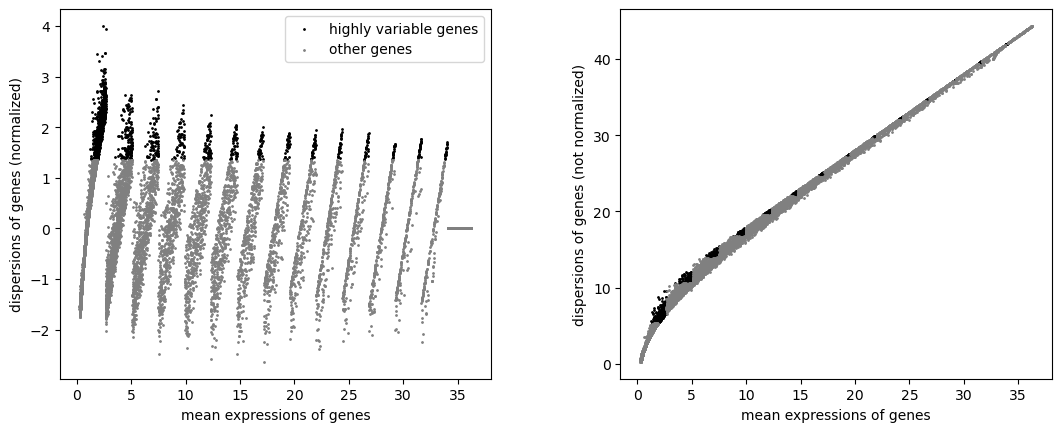

In [12]:
#@title Feature Selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

## PCA

/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


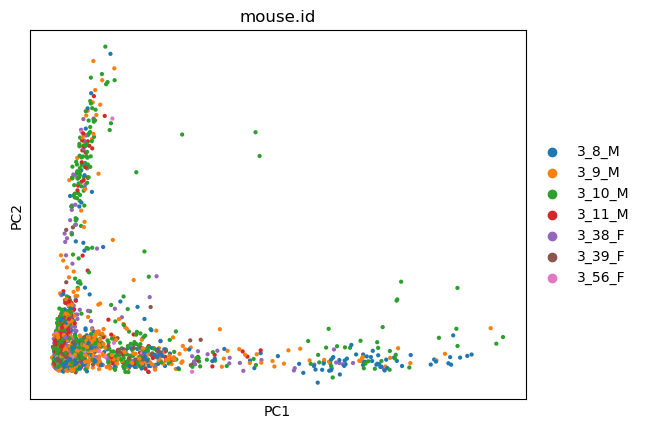

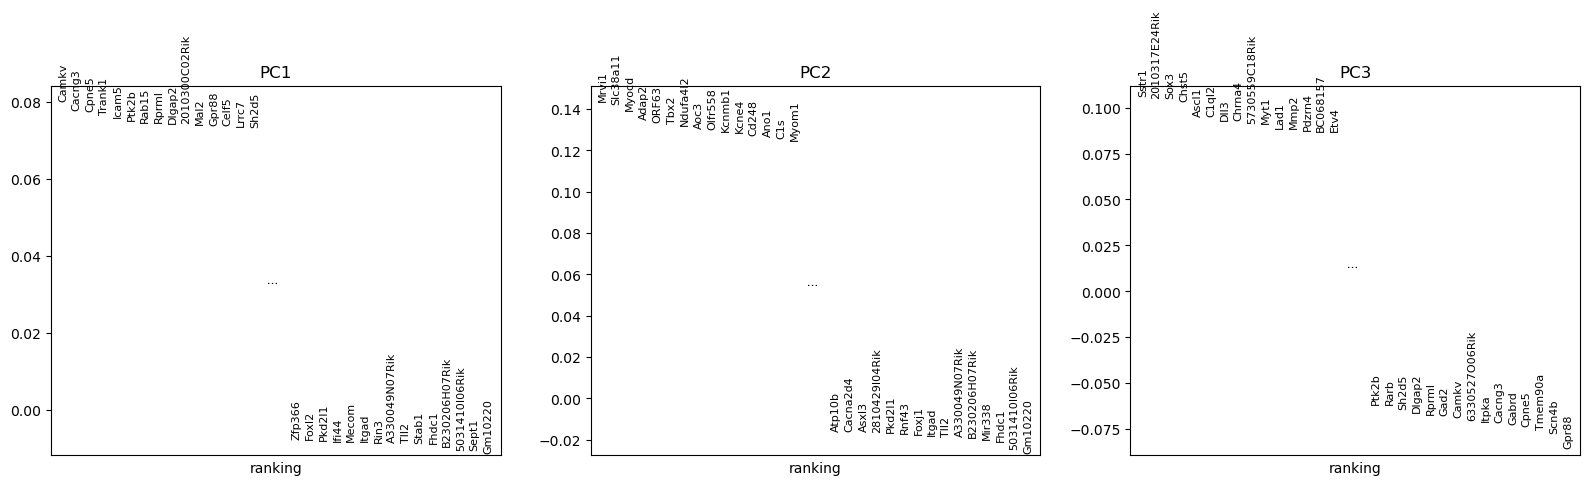

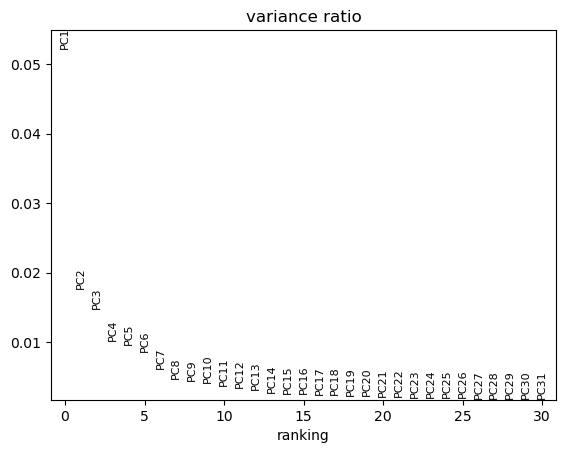

In [13]:
adata = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata)
sc.pl.pca_overview(adata, color='mouse.id')

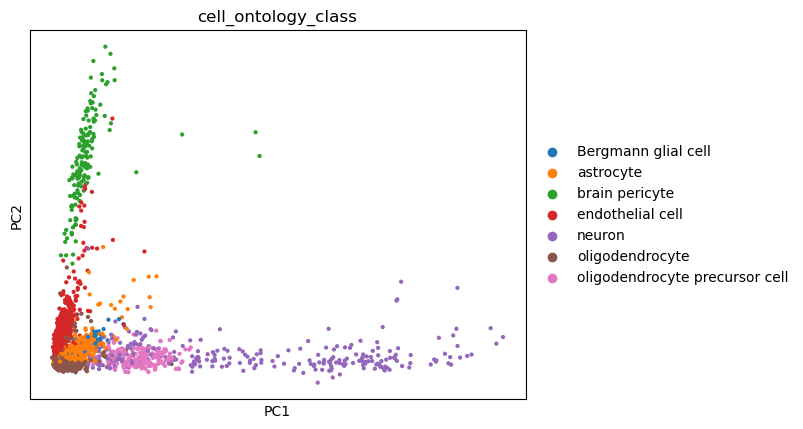

In [14]:
sc.pl.pca(adata,color='cell_ontology_class')

## UMAP

In [15]:
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

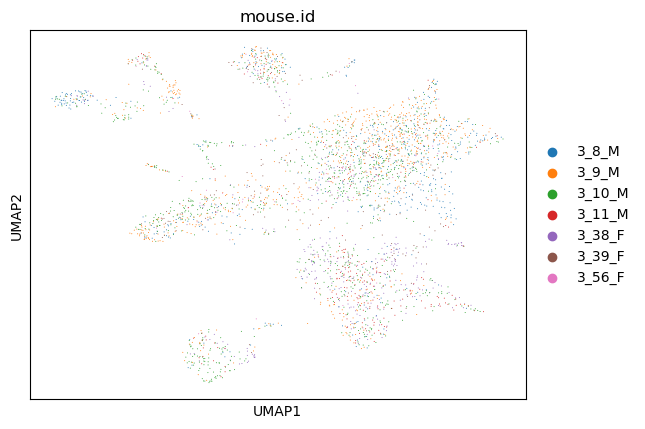

In [16]:
sc.pl.umap(
    adata,
    color="mouse.id",
    # Setting a smaller point size to get prevent overlap
    size=2,
)#little batch effect based on differnet mouse id

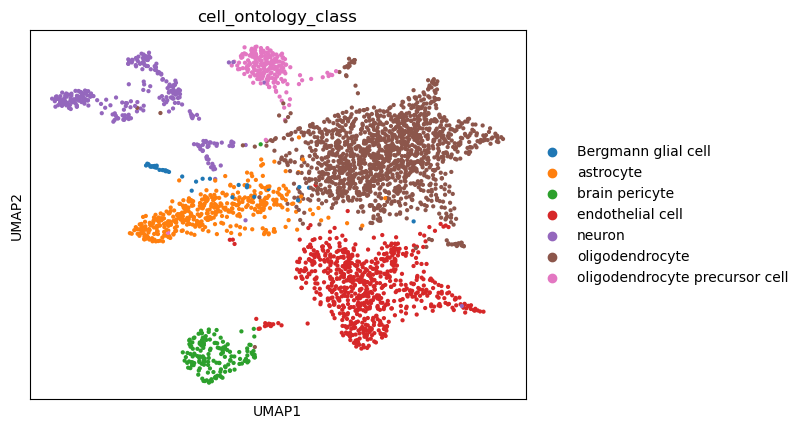

In [17]:
sc.pl.umap(adata,color='cell_ontology_class')

## tSNE

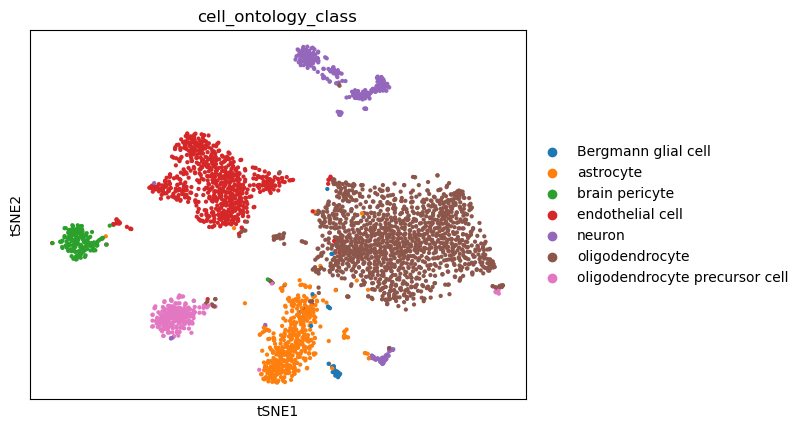

In [18]:
# tSNE
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)  # add X_tsne in obsm

sc.pl.tsne(adata, color='cell_ontology_class')  # Plots using X_tsne which is tSNE coordina

In [19]:
# Save data
adata.write('../data/brain_embeddings.h5ad')